In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

import scanpy as sc, anndata as ad
import squidpy as sq

from scipy.stats import linregress

In [145]:
# Load single-cell RNA cycleHCR data from RNA spot-to-cell assignment

df = pd.read_csv("cell_by_transcript_gene_name_matrix.csv", index_col=0)

In [146]:
# Convert to AnnData object
adata = ad.AnnData(X=df)

# name rows and columns
adata.obs_names = df.index.astype(str)  # cell IDs
adata.var_names = df.columns.astype(str)  # gene names

C:\Users\liany\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [149]:
# Load center-of-mass of Cellpose masks for spatial positions

spatial_df = pd.read_csv("center_of_mass_results.csv")
spatial_df['Label'] = spatial_df['Label'].astype(str)

spatial_df = spatial_df.set_index("Label")
# spatial_df = spatial_df.loc[adata.obs_names]

common_ids = adata.obs_names.intersection(spatial_df.index)

adata = adata[common_ids, :].copy()
spatial_df = spatial_df.loc[common_ids]

spatial_ar = spatial_df[["X", "Y", "Z"]].to_numpy()
adata.obsm['spatial3d']=spatial_ar
adata.obsm['spatial']=spatial_ar[:,:-1]
adata.obs['z_layer']=spatial_ar[:,-1]

<Axes: xlabel='cell_sums', ylabel='Count'>

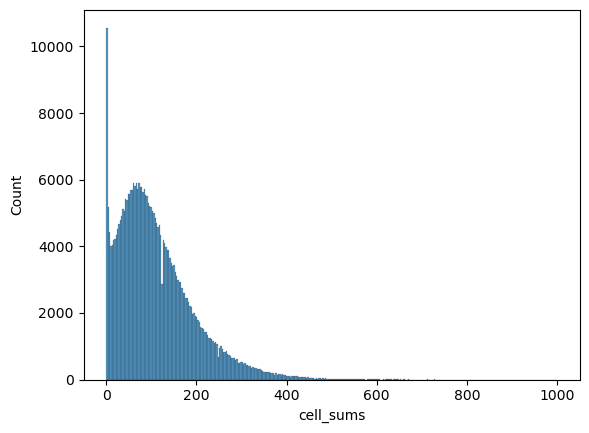

In [151]:
# Check distribution of spot counts per cell

adata.obs["cell_sums"] = adata.X.sum(axis=1)
sns.histplot(adata.obs["cell_sums"], binrange = (0,1000))

<Axes: xlabel='gene_sums', ylabel='Count'>

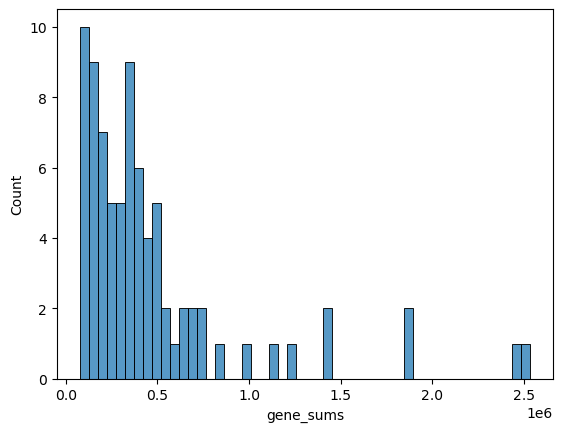

In [124]:
# Check distribution of spot counts per gene

adata.var["gene_sums"] = np.ravel(adata.X.sum(axis=0))
sns.histplot(adata.var["gene_sums"], bins = 50)

In [126]:
# filter out cells with less than 10 spot counts

sc.pp.filter_cells(adata, min_counts=10)

In [131]:
# preprocessing

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

In [133]:
# save preprocessed RNA matrix
# adata.write('RNA_processed_2nd_brain.h5ad')

In [135]:
# Load RNA matrix from another brain section, preprocessed the same way

adata_1st_brain = ad.read_h5ad("./first_brain_measurement/filtered_RNA_matrix.h5ad")

In [137]:
# Check common genes in two matrices
common_genes = adata_1st_brain.var_names.intersection(adata.var_names)
common_genes

Index([''Vip'', ''Ttr'', ''Sox9'', ''Slc17a6'', ''Slc17a7'', ''Slc17a8'',
       ''Slc32a1'', ''Slc6a5'', ''Chat'', ''Slc6a4'', ''Tph2'', ''Slc6a3'',
       ''Slc6a2'', ''Dbh'', ''Phox2b'', ''Gad1'', ''Gad2'', ''Aldh1a1'',
       ''Slc18a2'', ''Th'', ''Ddc'', ''Hdc'', ''Maoa'', ''Calb2'', ''Ndrg2'',
       ''Tiam1'', ''Prox1'', ''Dgat2'', ''Celsr2'', ''Wfs1'', ''Ngef'',
       ''Sv2b'', ''Sv2a'', ''Sox10'', ''Pdgfra'', ''Csf3r'', ''Sspo'',
       ''Spdef'', ''Myb'', ''Ccdc153'', ''Ikzf1'', ''Ptprc'', ''Slc1a3'',
       ''Slc1a2'', ''Fabp7'', ''Strip2'', ''Avpr1b'', ''Tcf7l2'', ''Lef1'',
       ''Six3'', ''Satb2'', ''Neurod6'', ''Bcl11b'', ''Reln'', ''Rorb'',
       ''Tmem215'', 'Pvalb'', ''Cnr1'', ''Olig2'', ''Rbfox3'', ''Aif1'',
       ''Nos1'', ''Mbp'', ''Nefh'', ''Nefm'', ''Dlg4'', ''Homer1'', ''Bsn'',
       ''Mki67'', ''Ank3'', ''Vim'', ''Pecam1'', ''Cdh1'', ''Cdh2'', ''Foxp2'',
       ''Fos'', ''Cadps'', ''Cpe'', ''Gabbr2''],
      dtype='object')

In [139]:
len(common_genes)

79

R 0.894818633205092 p-value 1.0844018010946502e-28


C:\Users\liany\AppData\Local\Temp\ipykernel_40036\1438786812.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


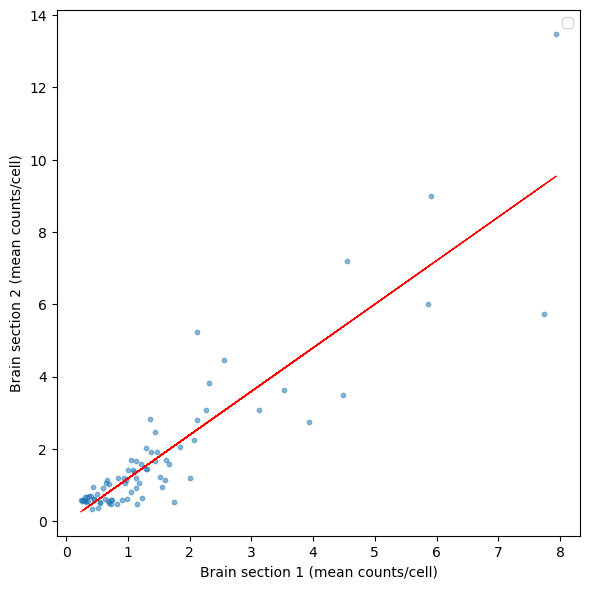

In [141]:
# plot average raw RNA counts per cell

# Subset both
X1 = adata_1st_brain[:, common_genes].layers["counts"]
X2 = adata[:, common_genes].layers["counts"]

# Convert sparse to dense if needed
if not isinstance(X1, np.ndarray):
    X1 = X1.toarray()
if not isinstance(X2, np.ndarray):
    X2 = X2.toarray()

# Mean expression per gene
gexp2 = np.mean(X1, axis=0)
gexp1 = np.mean(X2, axis=0)

# Correlation coefficient
corr_value = np.corrcoef(gexp1, gexp2)[0,1]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(gexp1, gexp2)
fit_line = slope * gexp1 + intercept

# Scatter + fit line
plt.figure(figsize=(6,6))
plt.scatter(gexp1, gexp2, alpha=0.5, s=10)
plt.plot(gexp1, fit_line, color="red", linewidth=0.8)

plt.xlabel("Brain section 1 (mean counts/cell)")
plt.ylabel("Brain section 2 (mean counts/cell)")
# plt.title(f"Nuclear protein average level correlation: r = {corr_value:.3f}")
plt.legend()

print("R", r_value, "p-value", p_value)
plt.tight_layout()
# plt.savefig("gene_correlation_raw.eps", format='eps')
plt.show()
plt.close()

# plt.show()